In [1]:
## Importing all the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from math import *
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
## Read the input data files 
path = "C:/Users/XABARBAD/Desktop/Work/KPI Validation & Importance/Model 2/KPI_New_Files/Datasets/"
df = pd.read_excel(path+"Inter_Files.xlsx",sheet_name = "US_Post_Launch_New")

In [3]:
## Look at the input file
df

Title  Nielsen - Metrics First Choice_mean  \
0                              A Way Out                             0.002123   
1                                 Anthem                             0.010276   
2              Assassin's Creed: Odyssey                             0.004425   
3              Assassin's Creed: Origins                             0.005896   
4                          Battlefield V                             0.006261   
..                                   ...                                  ...   
66  Tom Clancy's Ghost Recon: Breakpoint                             0.001032   
67           Tom Clancy's The Division 2                             0.005165   
68                                 UFC 3                             0.001114   
69                           World War Z                             0.001579   
70                              WWE 2K19                             0.003421   

    Nielsen - Metrics Purchase interest - Def_mean  \
0                                         0.219762   
1                                         0.123008   
2                                         0.210185   
3                                         0.192846   
4                                         0.179090   
..                                             ...   
66                                        0.146833   
67                                        0.129922   
68                                        0.048912   
69                                        0.050637   
70                                        0.149922   

    Nielsen - Metrics Purchase interest - Def not_mean  \
0                                            0.171625    
1                                            0.221061    
2                                            0.142421    
3                                            0.128421    
4                                            0.177345    
..                                                ...    
66                                           0.236473    
67                                           0.233826    
68                                           0.076429    
69                                           0.078318    
70                                           0.243207    

    Nielsen - Metrics Purchase interest - Own/Preorder_mean  \
0                                            0.024256         
1                                            0.039172         
2                                            0.081175         
3                                            0.076513         
4                                            0.074297         
..                                                ...         
66                                           0.043118         
67                                           0.054730         
68                                           0.012231         
69                                           0.012541         
70                                           0.034209         

    Nielsen - Metrics Purchase interest - Prob_mean  \
0                                          0.338998   
1                                          0.285694   
2                                          0.427230   
3                                          0.389886   
4                                          0.378344   
..                                              ...   
66                                         0.321699   
67                                         0.313008   
68                                         0.112133   
69                                         0.109513   
70                                         0.304058   

    Nielsen - Metrics Unaided Awareness_mean  Google_US_mean  \
0                                   0.039078        2.892375   
1                                   0.097737        1.587873   
2                                   0.043837        9.109162   
3                                   0.0490

In [4]:
#### Functions to transform columns

def logTransform(x):
    if(x<=0):
        return 0
    else:
        return log(x)
    
def squareTransform(x):
    return pow(x,2)

def cubeTransform(x):
    return pow(x,3)

def squareRootTransform(x):
    if(x<=0):
        return 0
    else:
        return sqrt(x)

def cubeRootTransform(x):
    if(x<=0):
        return 0
    else:
        return x**(1./3)

In [5]:
#In case there are any missing values, replace them with the mean

def imputeData(df,titleColName):
    df1 = df.drop([titleColName],axis=1)
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    imputer.fit(df1.values)
    df2 = pd.DataFrame(imputer.transform(df1))
    df2.columns = df1.columns
    df2.index = df1.index
    df3 = pd.concat([df[[titleColName]],df2],axis=1)
    return df3

df = imputeData(df, 'Title')

In [6]:
#Apply transformation to every column in the dataset

def getTransformedDF(df,titleColName):
    df2 = df.drop([titleColName],axis=1)
    cols = df2.columns
    df1 = df2[cols]
    for col in cols:
        df1['log('+col+')'] = df1[col].apply(lambda x:logTransform(x))
        df1['square('+col+')'] = df1[col].apply(lambda x:squareTransform(x))
        df1['cube('+col+')'] = df1[col].apply(lambda x:cubeTransform(x))
        df1['squareRoot('+col+')'] = df1[col].apply(lambda x:squareRootTransform(x))
        df1['cubeRoot('+col+')'] = df1[col].apply(lambda x:cubeRootTransform(x))
    df3 = pd.concat([df[[titleColName]],df1],axis=1)
    return df3

titleColName = 'Title'
df_transformed = getTransformedDF(df,titleColName)
df_transformed.shape

(71, 433)

In [9]:
### Get Col Names in Sequence so as to clearly visualise correlation
### Can be skipped

def getColsListSortedOrder(colsList,cols):
    colsNewList = []
    for stg in colsList:
        for col in cols:
            if(col.find(stg)!=-1):
                colsNewList.append(col)

    for col in cols:
        if col not in colsNewList:
            colsNewList.append(col)
        
    unique_col_list  = []    
    for col in colsNewList:
        if(col not in unique_col_list):
            unique_col_list.append(col)
    
    return unique_col_list

In [10]:
#Get the shape of the dataset
df.shape

(71, 73)

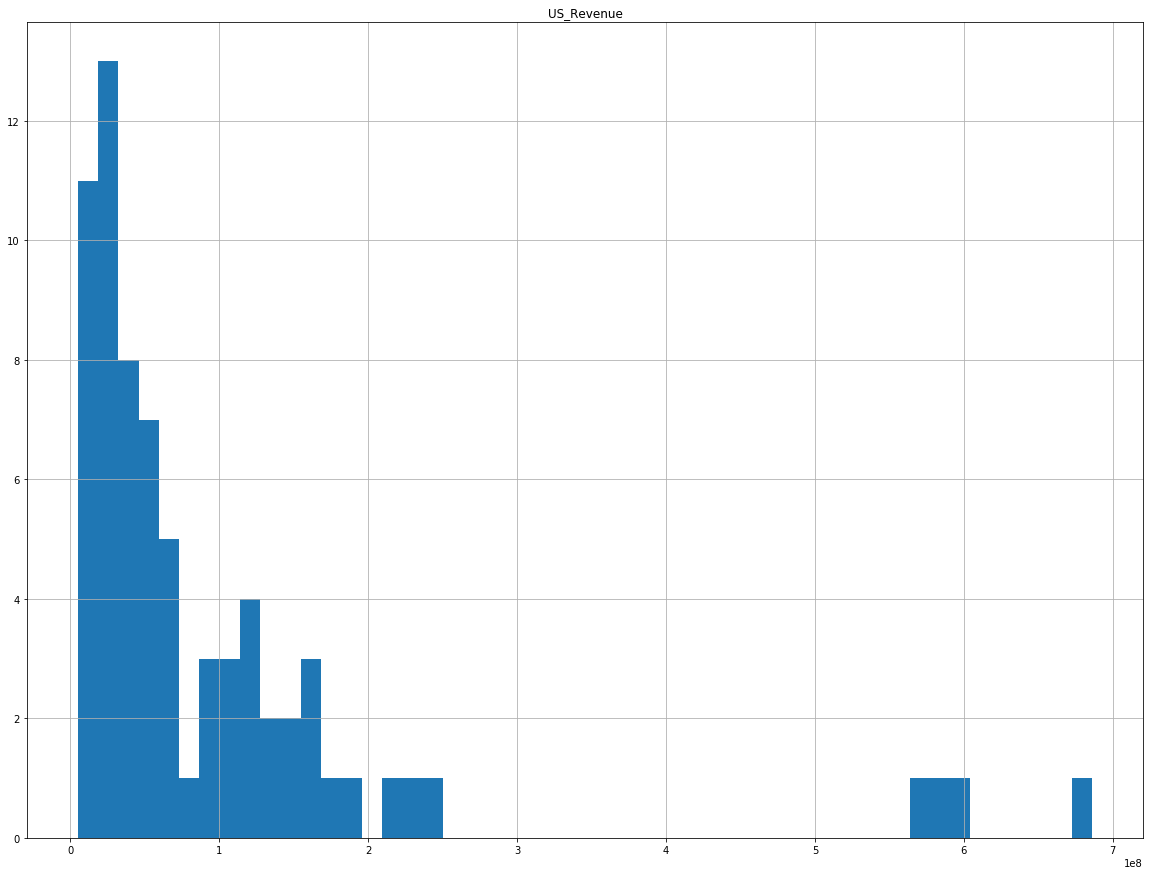

In [11]:
#Checking the distribution of US Revenue to identify outliers

%matplotlib inline
import matplotlib.pyplot as plt
df_transformed.hist(column = 'US_Revenue',bins = 50, figsize = (20,15))
plt.show()

In [12]:
#Remove outliers based on business knowledge & above plot.
titles = ['Call of Duty: Black Ops IIII','Call of Duty: WWII','Red Dead Redemption II', 
         'Call of Duty: Modern Warfare 2019']

df_transformed = df_transformed[~df_transformed.Title.isin(titles)]
df_transformed.shape

(67, 433)

In [13]:
#Removing more outliers by removing titles with revenue less than 16M
#16M was identified as the threshold because they had high error & we earlier saw a drop in error by deleting these

#Greater_than2m = df_transformed.US_Revenue > 16000000
#print(df_transformed[Greater_than2m].shape)
#df_transformed = df_transformed[Greater_than2m]

In [14]:
#### Linear Regression - Model 1
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))

### For VIF Analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [15]:
#Dropping title since it's a categorical variable & Revenue because we're checking for Variance inflation & don't
#need the dependent variable

df_revenue_model = df_transformed.drop(['US_Revenue', 'Title','log(US_Revenue)','cube(US_Revenue)',
                                       'squareRoot(US_Revenue)','cubeRoot(US_Revenue)','square(US_Revenue)'], axis = 1)
df_revenue_vif  = df_revenue_model.loc[:].astype(float)
df_revenue_vif.shape

(67, 426)

In [16]:
#Checking the Variance inflation factor of the independent variables

revenue_vif = variance_inflation_factors(df_revenue_vif)
revenue_vif
revenue_vif.shape

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(427,)

In [17]:
#Another method defined to calculate VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [18]:
#Drop columns with VIF higher than the threshold defined earlier - 5.0

df_vif = calculate_vif_(df_revenue_vif)
df_vif.shape
df_vif.columns

dropping 'cube(Netbase - Metrics Impressions_max)' at index: 303
dropping 'cube(Netbase - Metrics Posts_max)' at index: 312
dropping 'cube(Netbase - Metrics Mentions_mean)' at index: 163
dropping 'square(Netbase - Metrics Impressions_max)' at index: 301
dropping 'cube(Marketing Metrics PR Metrics and Articles_mean)' at index: 113
dropping 'cube(Marketing Metrics Twitter Activity_mean)' at index: 122
dropping 'square(Netbase - Metrics Mentions_max)' at index: 302
dropping 'square(Netbase - Metrics Impressions_mean)' at index: 155
dropping 'cube(Netbase - Metrics Posts_mean)' at index: 164
dropping 'cube(Marketing Metrics Twitter Activity_max)' at index: 263
dropping 'square(Netbase - Metrics Mentions_mean)' at index: 159
dropping 'cube(Tubular - Metrics Views_mean)' at index: 151
dropping 'cube(Marketing Metrics Views_max)' at index: 265
dropping 'square(Netbase - Metrics Posts_max)' at index: 300
dropping 'square(Marketing Metrics PR Metrics and Articles_max)' at index: 250
dropping 's

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


dropping 'square(Tubular - Metrics Uploads_mean)' at index: 132
dropping 'cube(Tubular - Metrics Uploads_max)' at index: 254
dropping 'Netbase - Metrics Impressions_mean' at index: 17
dropping 'cube(Sentiment_ambivalent_mean)' at index: 167
dropping 'Netbase - Metrics Posts_mean' at index: 17
dropping 'square(Reach_mean)' at index: 160
dropping 'cube(Marketing Metrics PR Metrics and Articles_max)' at index: 223
dropping 'square(Sentiment_ambivalent_mean)' at index: 164
dropping 'square(Sentiment_ambivalent_max)' at index: 283
dropping 'cube(Marketing Metrics Views_mean)' at index: 116
dropping 'square(Sentiment_neutral_max)' at index: 295
dropping 'cube(Netbase - Metrics Totalreposts_mean)' at index: 147
dropping 'Marketing Metrics PR Metrics and Articles_mean' at index: 8
dropping 'cube(Tubular - Metrics Engagements_mean)' at index: 124
dropping 'Tubular - Metrics Views_mean' at index: 15
dropping 'Tubular - Metrics Engagements_mean' at index: 13
dropping 'Netbase - Metrics Posts_max'

Index(['Nielsen - Metrics First Choice_mean',
       'Nielsen - Metrics Purchase interest - Def_mean',
       'Nielsen - Metrics Purchase interest - Def not_mean',
       'Nielsen - Metrics Purchase interest - Own/Preorder_mean',
       'Nielsen - Metrics Purchase interest - Prob_mean',
       'Nielsen - Metrics Unaided Awareness_mean', 'Google_US_mean',
       'Marketing Metrics Net Sentiment_mean', 'Reach_mean',
       'Sentiment_negative_mean',
       ...
       'log(Metacritic Score)', 'square(Metacritic Score)',
       'cube(Metacritic Score)', 'squareRoot(Metacritic Score)',
       'cubeRoot(Metacritic Score)', 'log(User Review Score)',
       'square(User Review Score)', 'cube(User Review Score)',
       'squareRoot(User Review Score)', 'cubeRoot(User Review Score)'],
      dtype='object', length=321)

In [19]:
#Trying out variable selections. 
#Checking correlation.
#cols_corr = ['US_Revenue','Marketing Metrics Unaided Awareness_mean','squareRoot(Nielsen - Metrics Unaided Awareness_mean)',
#            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
#            'squareRoot(Tubular - Metrics Views_mean)','Youtube_US_mean','Google_US_mean']
#df_corr = df_transformed[cols_corr]

In [20]:
#Using Pearson correlation
#import seaborn as sns
#plt.figure(figsize = (12,10))
#cor = df_corr.corr()
#sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)
#plt.show()

In [19]:
#Correlation with output variable
#cor_target = abs(cor["US_Revenue"])

#Selecting highly correlated features
#relevant_features = cor_target[cor_target > 0.5]
#relevant_features

#print(df_corr[["Youtube_US_mean", "Google_US_mean"]].corr())

In [20]:
#Wrapper method for variable selection.
#Backward elimination. 

df_rev_only = df_transformed.drop(['Title','log(US_Revenue)','cube(US_Revenue)','squareRoot(US_Revenue)','cubeRoot(US_Revenue)','square(US_Revenue)'], axis = 1)
df_rev  = df_rev_only.loc[:].astype(float)
df_rev.shape

#In backward elimination - we only keep variables > 0.5
X = df_rev.drop(['US_Revenue'], axis = 1)
#X.shape
y_name = "US_Revenue"
Y = df_rev[y_name]
#Y.shape

In [21]:
#Backward elimination continued - 
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

X_1 = sm.add_constant(X)

#Fitting sm.ols model
model = sm.OLS(Y,X_1).fit()
model.pvalues

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


const                                                      0.022033
Nielsen - Metrics First Choice_mean                        0.022036
Nielsen - Metrics Purchase interest - Def_mean             0.022034
Nielsen - Metrics Purchase interest - Def not_mean         0.022035
Nielsen - Metrics Purchase interest - Own/Preorder_mean    0.022035
                                                             ...   
log(User Review Score)                                     0.022041
square(User Review Score)                                  0.022040
cube(User Review Score)                                    0.022040
squareRoot(User Review Score)                              0.022041
cubeRoot(User Review Score)                                0.022041
Length: 427, dtype: float64

In [22]:
#Backward elimination of variables with p-value > 0.05
cols = list(X.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['Nielsen - Metrics First Choice_mean', 'Marketing Metrics Views_mean', 'Top_Games_3M', 'cubeRoot(Nielsen - Metrics Purchase interest - Def_mean)', 'cubeRoot(Nielsen - Metrics Purchase interest - Def not_mean)', 'log(Nielsen - Metrics Purchase interest - Prob_mean)', 'log(Nielsen - Metrics Unaided Awareness_mean)', 'square(Nielsen - Metrics Unaided Awareness_mean)', 'squareRoot(Google_US_mean)', 'cubeRoot(Marketing Metrics PR Metrics and Articles_mean)', 'log(Marketing Metrics Views_mean)', 'square(Marketing Metrics Views_mean)', 'cube(Marketing Metrics Views_mean)', 'log(Marketing Metrics Unaided Awareness_mean)', 'squareRoot(Marketing Metrics Unaided Awareness_mean)', 'cubeRoot(Marketing Metrics Unaided Awareness_mean)', 'log(Marketing Metrics UCGs_mean)', 'squareRoot(Marketing Metrics UCGs_mean)', 'log(Tubular - Metrics Engagements_mean)', 'squareRoot(Tubular - Metrics Engagements_mean)', 'log(Tubular - Metrics Views_mean)', 'squareRoot(Tubular - Metrics Views_mean)', 'cubeRoot(Tubu

In [23]:
#Importing the relevant packages.
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#Trying RFE on this model
df_rfe_model = df_rev_only[cols]
df_rfe_complete = df_rev_only

#Initializing the model
model = LinearRegression()

rfe = RFE(model,7)

#Transforming the data using RFE.
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model.
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [24]:
#This part is to identify the top variables to be later used in the model

#What is the ideal set of variables.
#No of features.
#df_rev_complete = df_rev_only

nof_list = np.arange(1,20)
high_score = 0

X = df_rev_only.drop(['US_Revenue'], axis = 1)
X = X[cols]

X.shape
y_name = "US_Revenue"
Y = df_rev_only[y_name]
Y.shape

#Variable to store the optimum features.
nof = 0
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features 4
Score with 4 features: 0.858010


In [25]:
#Listing the top variables to be used in the model later
#This is a good point to check which variables make sense to be kept in the model & which to be removed

cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model,40)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to the model
model.fit(X_rfe, Y)
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['cubeRoot(Nielsen - Metrics Purchase interest - Def not_mean)',
       'square(Nielsen - Metrics Unaided Awareness_mean)',
       'log(Marketing Metrics Unaided Awareness_mean)',
       'log(Marketing Metrics UCGs_mean)',
       'log(Netbase - Metrics Mentions_mean)',
       'log(Netbase - Metrics Totalreposts_mean)',
       'squareRoot(Sentiment_ambivalent_mean)',
       'cubeRoot(Sentiment_ambivalent_mean)',
       'squareRoot(Nielsen - Metrics First Choice_max)',
       'cubeRoot(Nielsen - Metrics First Choice_max)',
       'log(Nielsen - Metrics Purchase interest - Def_max)',
       'squareRoot(Nielsen - Metrics Purchase interest - Def_max)',
       'cubeRoot(Nielsen - Metrics Purchase interest - Def_max)',
       'log(Nielsen - Metrics Purchase interest - Def not_max)',
       'square(Nielsen - Metrics Purchase interest - Def not_max)',
       'squareRoot(Nielsen - Metrics Purchase interest - Def not_max)',
       'log(Nielsen - Metrics Purchase interest - Own/Preorder_max)

In [95]:
#Selecting the top metrics from the above method + business context
cols_vif = ['log(Netbase - Metrics Mentions_mean)','log(Netbase - Metrics Posts_mean)',
             'Google_US_mean','cube(Tubular - Metrics Views_mean)','log(Netbase - Metrics Totalreposts_mean)',
            'Nielsen - Metrics First Choice_mean','cube(Nielsen - Metrics Purchase interest - Def_mean)',
           'squareRoot(Marketing Metrics Net Sentiment_mean)',
           'log(Netbase - Metrics Impressions_mean)', 
           'squareRoot(Article Count_mean)', 'log(Reach_mean)', 'square(Nielsen - Metrics Unaided Awareness_mean)']

In [96]:
#Subset the dataset & keep only the important variables
df_rev_vif = df_revenue_vif[cols_vif]
df_rev_vif.head()

log(Netbase - Metrics Mentions_mean)  log(Netbase - Metrics Posts_mean)  \
0                              9.904542                           9.594313   
1                             12.286434                          11.575344   
2                             12.628983                          12.303260   
3                             12.204814                          11.763695   
4                             12.585714                          11.987310   

   Google_US_mean  cube(Tubular - Metrics Views_mean)  \
0        2.892375                        1.787439e+21   
1        1.587873                        2.294252e+20   
2        9.109162                        6.178171e+21   
3        7.675244                        1.324834e+22   
4        8.573368                        1.931193e+22   

   log(Netbase - Metrics Totalreposts_mean)  \
0                                  8.160246   
1                                  9.717961   
2                                 11.319049   
3                                 10.362358   
4                                 10.784457   

   Nielsen - Metrics First Choice_mean  \
0                             0.002123   
1                             0.010276   
2                             0.004425   
3                             0.005896   
4                             0.006261   

   cube(Nielsen - Metrics Purchase interest - Def_mean)  \
0                                           0.010613      
1                                           0.001861      
2                                           0.009286      
3                                           0.007172      
4                                           0.005744      

   squareRoot(Marketing Metrics Net Sentiment_mean)  \
0                                          0.792967   
1                                          0.000000   
2                                          0.794021   
3                                          0.853927   
4                                          0.539198   

   log(Netbase - Metrics Impressions_mean)  squareRoot(Article Count_mean)  \
0                                19.095016                        7.618899   
1                                20.464794                       65.794775   
2                                21.971845                       37.675936   
3                                21.507002                       17.067094   
4                                21.503307                       34.752184   

   log(Reach_mean)  square(Nielsen - Metrics Unaided Awareness_mean)  
0        18.821298                                          0.001527  
1        21.610945                                          0.009552  
2        21.235907                                          0.001922  
3        18.789976                                          0.002402  
4        20.974041                                          0.002977

In [97]:
#df_vif = df_vif[cols_vif]
#df_vif.shape

In [98]:
### For VIF Analysis

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [99]:
#Checking the VIF output for the subsetted variables
vif = variance_inflation_factors(df_rev_vif)
vif = vif.reset_index()
vif = vif.sort_values(by=['VIF'],ascending=0)
vif

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


index       VIF
4                  cube(Tubular - Metrics Views_mean)  1.769059
12   square(Nielsen - Metrics Unaided Awareness_mean)  0.769233
6                 Nielsen - Metrics First Choice_mean  0.619169
7   cube(Nielsen - Metrics Purchase interest - Def...  0.542662
10                     squareRoot(Article Count_mean)  0.433335
3                                      Google_US_mean  0.340192
11                                    log(Reach_mean)  0.069822
8    squareRoot(Marketing Metrics Net Sentiment_mean)  0.048291
5            log(Netbase - Metrics Totalreposts_mean)  0.034303
1                log(Netbase - Metrics Mentions_mean)  0.020459
2                   log(Netbase - Metrics Posts_mean)  0.019418
9             log(Netbase - Metrics Impressions_mean)  0.004876
0                                               const  0.000000

In [100]:
#Checking the correlation of the selected variables
df_rev_vif.corr()

log(Netbase - Metrics Mentions_mean)  \
log(Netbase - Metrics Mentions_mean)                                            1.000000   
log(Netbase - Metrics Posts_mean)                                               0.925233   
Google_US_mean                                                                  0.392032   
cube(Tubular - Metrics Views_mean)                                              0.089235   
log(Netbase - Metrics Totalreposts_mean)                                        0.808288   
Nielsen - Metrics First Choice_mean                                             0.363963   
cube(Nielsen - Metrics Purchase interest - Def_...                              0.151457   
squareRoot(Marketing Metrics Net Sentiment_mean)                               -0.068468   
log(Netbase - Metrics Impressions_mean)                                         0.780534   
squareRoot(Article Count_mean)                                                  0.447402   
log(Reach_mean)                                                                 0.373071   
square(Nielsen - Metrics Unaided Awareness_mean)                                0.297705   

                                                    log(Netbase - Metrics Posts_mean)  \
log(Netbase - Metrics Mentions_mean)                                         0.925233   
log(Netbase - Metrics Posts_mean)                                            1.000000   
Google_US_mean                                                               0.468434   
cube(Tubular - Metrics Views_mean)                                           0.108684   
log(Netbase - Metrics Totalreposts_mean)                                     0.883176   
Nielsen - Metrics First Choice_mean                                          0.442817   
cube(Nielsen - Metrics Purchase interest - Def_...                           0.222100   
squareRoot(Marketing Metrics Net Sentiment_mean)                            -0.051181   
log(Netbase - Metrics Impressions_mean)                                      0.833167   
squareRoot(Article Count_mean)                                               0.426767   
log(Reach_mean)                                                              0.361968   
square(Nielsen - Metrics Unaided Awareness_mean)                             0.360400   

                                                    Google_US_mean  \
log(Netbase - Metrics Mentions_mean)                      0.392032   
log(Netbase - Metrics Posts_mean)                         0.468434   
Google_US_mean                                            1.000000   
cube(Tubular - Metrics Views_mean)                       -0.034971   
log(Netbase - Metrics Totalreposts_mean)                  0.417836   
Nielsen - Metrics First Choice_mean                       0.292644   
cube(Nielsen - Metrics Purchase interest - Def_...        0.245503   
squareRoot(Marketing Metrics Net Sentiment_mean)          0.045496   
log(Netbase - Metrics Impressions_mean)                   0.492026   
squareRoot(Article Count_mean)                            0.271489   
log(Reach_mean)                                           0.175760   
square(Nielsen - Metrics Unaided Awareness_mean)          0.269463   

                                                    cube(Tubular - Metrics Views_mean)  \
log(Netbase - Metrics Mentions_mean)                                          0.089235   
log(Netbase - Metrics Posts_mean)                                             0.108684   
Google_US_mean                                                               -0.034971   
cube(Tubular - Metrics Views_mean)                                            1.000000   
log(Netbase - Metrics Totalreposts_mean)                                      0.122262   
Nielsen - Metrics First Choice_mean                                           0.318157   
cube(Nielsen - Metrics Purchase interest - Def_...                            0.008416   
squareRoot(Marketing Metrics Net Sentiment_mean)                  

In [101]:
#Creating two datasets - X: Only dependent variables, Y: Only independent variables.

X = df_rev_vif.copy()
X.shape
y_name = "US_Revenue"
Y = df_transformed[y_name]
Y.shape

(67,)

In [102]:
#Checking the values of the revenue dataset

Y

0     1.458897e+07
1     8.611137e+07
2     9.877498e+07
3     1.266272e+08
4     1.598051e+08
          ...     
66    5.416103e+07
67    1.042348e+08
68    2.547165e+07
69    4.942026e+06
70    2.972428e+07
Name: US_Revenue, Length: 67, dtype: float64

In [103]:
#Importing statsmodel library in order to perform Linear Regression

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

def getSplitTrainTest(df_X,df_Y,testSize,seed):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=seed)
    return (X_train,X_test,Y_train,Y_test)

def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,rank):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    dfResid = len(yoriginal) - rank
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/dfResid
    return adjusted_r_squared
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))


In [104]:
## Cross Validation Model for both RF and XGB. Uncomment the one which is required
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(X)
print("Shape is = ",X.shape)
print("Rank is = ",rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}

### Original RF Model
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)

### RF model for less than 3 variables
#rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=1,random_state=7)
# rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(X.shape[1]/3),random_state=7)
# rf= RandomForestRegressor(n_estimators=2000,max_depth=10,max_features=int(X.shape[1]/3),random_state=7)
# predictions = cross_val_predict(rf,X,Y, cv=4) 
# scores = cross_validate(rf,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)

### XGB Model
gbm = xgb.XGBRegressor(n_estimators=25,max_depth=4,max_features=int(X.shape[1]/3),learing_rate=0.001,subsample = 0.55,random_state=7)
predictions = cross_val_predict(gbm,X,Y, cv=4) 
scores = cross_validate(gbm,X,Y,cv=4,scoring = scoring,return_train_score=True,return_estimator=True)


Shape is =  (67, 12)
Rank is =  1
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

In [105]:
#Checking the scores of the XGBoost Regressor model
scores

{'fit_time': array([0.00993371, 0.00794268, 0.00598264, 0.00797892]),
 'score_time': array([0.00698161, 0.00399041, 0.00498819, 0.00498676]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=4, min_child_weight=1,
               missing=None, n_estimators=25, n_jobs=1, nthread=None,
               objective='reg:linear', random_state=7, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=None, subsample=0.55,
               verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learing_rate=0.001, learning_rate=0.1,
               max_delta_step=0, max_depth=4, max_features=4, min_child_weight=1,
 

In [106]:
#Checking model metrics for the XGBoost model

print("Test mape = ",scores['test_mape'].mean())
print("Train mape= ",scores['train_mape'].mean())
print("Test Wmape = ",scores['test_wmape'].mean())
print("Train Wmape = ",scores['train_wmape'].mean())
print("Train Rsquare = ",scores['train_Rsquare'].mean())
print("Train adjRsquare = ",scores['train_adjRsquare'].mean())

Test mape =  58.09184847081599
Train mape=  22.442759301530042
Test Wmape =  39.36309964504348
Train Wmape =  19.31232849088804
Train Rsquare =  0.8512701145856669
Train adjRsquare =  0.8512701145856669


In [107]:
##For Feature Importance of the XGBoost model
df_model_cv_prediction = df_transformed[[y_name]]
feature_importances = pd.DataFrame()
feature_importances['Features'] = X.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(X)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Features   model_0   model_1  \
5                 Nielsen - Metrics First Choice_mean  0.275652  0.216565   
2                                      Google_US_mean  0.094844  0.265172   
6   cube(Nielsen - Metrics Purchase interest - Def...  0.103309  0.123477   
10                                    log(Reach_mean)  0.168796  0.069062   
11   square(Nielsen - Metrics Unaided Awareness_mean)  0.117790  0.081977   
3                  cube(Tubular - Metrics Views_mean)  0.051476  0.035885   
8             log(Netbase - Metrics Impressions_mean)  0.028211  0.029860   
1                   log(Netbase - Metrics Posts_mean)  0.030023  0.011073   
9                      squareRoot(Article Count_mean)  0.044399  0.024996   
0                log(Netbase - Metrics Mentions_mean)  0.029898  0.042036   
4            log(Netbase - Metrics Totalreposts_mean)  0.008937  0.070077   
7    squareRoot(Marketing Metrics Net Sentiment_mean)  0.046665  0.029819   

     model_2   model_3      mean  
5   0.108892  0.344269  0.236345  
2   0.139446  0.113085  0.153137  
6   0.060538  0.172395  0.114930  
10  0.043591  0.101510  0.095740  
11  0.104642  0.035311  0.084930  
3   0.166667  0.049832  0.075965  
8   0.159835  0.038698  0.064151  
1   0.138281  0.015998  0.048844  
9   0.020956  0.057413  0.036941  
0   0.031694  0.027350  0.032745  
4   0.010744  0.029051  0.029702  
7   0.014714  0.015088  0.026572

In [108]:
#Checking for the error in prediction by comparing model output with the actual values
df_model_cv_prediction['Title'] = df_transformed['Title']
df_model_cv_prediction['Error'] = df_model_cv_prediction.US_Revenue - df_model_cv_prediction['mean']
df_model_cv_prediction['AbsError'] = abs(df_model_cv_prediction['Error'])
df_model_cv_prediction['PercentError'] = (df_model_cv_prediction['AbsError']/df_model_cv_prediction.US_Revenue)*100
df_model_cv_prediction = df_model_cv_prediction.sort_values(by = 'PercentError',ascending=False)
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is t

US_Revenue      model_0      model_1      model_2      model_3  \
69  4.942026e+06   13288470.0   15159394.0   15108264.0   34975324.0   
32  3.042598e+07   61668752.0   83315568.0   54005088.0   42026412.0   
46  8.204588e+06   17243368.0    9858696.0   22562162.0   14962826.0   
20  2.383544e+07   32472536.0   59206712.0   42752892.0   34127844.0   
0   1.458897e+07   26067006.0   24162602.0   26542646.0   22087902.0   
..           ...          ...          ...          ...          ...   
21  1.528531e+08  152926000.0  151866032.0  148104160.0  143101664.0   
2   9.877498e+07   88703040.0   90652864.0  102427152.0  104594448.0   
42  2.368631e+07   23083232.0   20266534.0   30645946.0   19515942.0   
17  1.012719e+08  117838192.0   89170008.0  100779680.0  100944560.0   
64  1.016675e+08   95180104.0   92464736.0   95787992.0  122598112.0   

            mean                                    Title         Error  \
69  1.669470e+07                              World War Z -1.175267e+07   
32  5.428836e+07                             Mario Kart 8 -2.386238e+07   
46  1.456633e+07                                   Rage 2 -6.361740e+06   
20  3.847909e+07                                  Gears 5 -1.464364e+07   
0   2.268983e+07                                A Way Out -8.100855e+06   
..           ...                                      ...           ...   
21  1.497702e+08                          God of War 2018  3.082878e+06   
2   9.703050e+07                Assassin's Creed: Odyssey  1.744483e+06   
42  2.343959e+07                                   NHL 19  2.467158e+05   
17  1.020009e+08                                  FIFA 19 -7.289590e+05   
64  1.015397e+08  The Legend of Zelda: Breath of the Wild  1.278472e+05   

        AbsError  PercentError  
69  1.175267e+07    237.810762  
32  2.386238e+07     78.427665  
46  6.361740e+06     77.538804  
20  1.464364e+07     61.436420  
0   8.100855e+06     55.527254  
..           ...           ...  
21  3.082878e+06      2.016890  
2   1.744483e+06      1.766119  
42  2.467158e+05      1.041597  
17  7.289590e+05      0.719804  
64  1.278472e+05      0.125750  

[67 rows x 10 columns]

In [109]:
#Exporting the model output
df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//Post_Launch_Pred_0625_cis.xlsx")

In [110]:
### Cross Validation for Linear Regression
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
lm= linear_model.LinearRegression()
np.random.seed(7)
predictions = cross_val_predict(lm, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
#print(predictions)
scores = cross_validate(lm,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 12)
1


In [111]:
#Print model's predictions & intercepts
print(scores['estimator'][0].predict(df_rev_vif))
scores['estimator'][0].intercept_

[6.78634956e+07 6.78632508e+07 6.78641856e+07 6.78652966e+07
 6.78662494e+07 6.78687290e+07 6.78632275e+07 6.78662033e+07
 6.78777982e+07 6.78747987e+07 6.78767611e+07 6.78646107e+07
 6.78760589e+07 6.78638483e+07 1.02654889e+08 6.79247075e+07
 6.78662430e+07 6.78636174e+07 6.79934120e+07 6.78632313e+07
 6.78632180e+07 6.78632802e+07 6.78633027e+07 6.78659485e+07
 6.78632159e+07 6.78632796e+07 6.78655516e+07 6.78632524e+07
 6.78634382e+07 6.78731700e+07 6.78703181e+07 6.78632175e+07
 6.78632255e+07 6.78643224e+07 6.79481962e+07 6.78632313e+07
 6.78697290e+07 6.78642301e+07 6.78731700e+07 6.78632169e+07
 6.78632148e+07 6.98144719e+07 6.79109119e+07 6.78632519e+07
 6.78832895e+07 6.78639603e+07 6.78763930e+07 6.78632346e+07
 6.78633086e+07 6.78638423e+07 6.78632148e+07 6.78736642e+07
 6.78649488e+07 6.78632275e+07 6.78937080e+07 6.78890105e+07
 6.78654128e+07 6.79869238e+07 6.78632149e+07 6.78634116e+07
 6.78935822e+07 6.78731700e+07 6.78637894e+07 6.78658322e+07
 6.78632624e+07 6.786356

67863214.76526177

In [112]:
#Print the model scores
scores

{'fit_time': array([0.00598359, 0.00398898, 0.00199509, 0.00199533, 0.00199461,
        0.00099707, 0.00199413, 0.00299215]),
 'score_time': array([0.00798273, 0.00797844, 0.00698185, 0.00598431, 0.00598383,
        0.00498652, 0.00398922, 0.00498676]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)),
 'test_Rsquare': array([-0.11504809, -3.38621083, -0.15352783, -0.32

In [113]:
#Check the error rates & the r-squared metrics

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())
# print(scores['test_wmape'].mean())
# print(scores['test_wmape'].mean())

79.67221096885643
68.01140322853064
0.004644485663011705
0.004644485663011705


In [114]:
#Getting the Revenue predictions from the model
scores['estimator'][1].predict(df_rev_vif)
df_model_cv_prediction = df_transformed[['US_Revenue']]
count = 0
for model in scores['estimator']:
    pred = model.predict(df_rev_vif)
    df_model_cv_prediction['model_'+str(count)] = pred
    count = count+1
df_model_cv_prediction

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

US_Revenue       model_0       model_1       model_2       model_3  \
0   1.458897e+07  6.786350e+07  6.866850e+07  7.299838e+07  6.661478e+07   
1   8.611137e+07  6.786325e+07  6.866552e+07  7.299818e+07  6.661452e+07   
2   9.877498e+07  6.786419e+07  6.867687e+07  7.299896e+07  6.661549e+07   
3   1.266272e+08  6.786530e+07  6.869036e+07  7.299988e+07  6.661664e+07   
4   1.598051e+08  6.786625e+07  6.870192e+07  7.300068e+07  6.661762e+07   
..           ...           ...           ...           ...           ...   
66  5.416103e+07  6.786379e+07  6.867206e+07  7.299863e+07  6.661508e+07   
67  1.042348e+08  6.786583e+07  6.869686e+07  7.300033e+07  6.661719e+07   
68  2.547165e+07  6.786326e+07  6.866567e+07  7.299819e+07  6.661453e+07   
69  4.942026e+06  6.786356e+07  6.866929e+07  7.299844e+07  6.661484e+07   
70  2.972428e+07  6.786359e+07  6.866965e+07  7.299846e+07  6.661487e+07   

         model_4       model_5       model_6       model_7  
0   7.166099e+07  7.467225e+07  6.661963e+07  7.333445e+07  
1   7.166077e+07  7.467206e+07  6.661938e+07  7.333424e+07  
2   7.166160e+07  7.467280e+07  6.662033e+07  7.333502e+07  
3   7.166259e+07  7.467368e+07  6.662147e+07  7.333594e+07  
4   7.166343e+07  7.467443e+07  6.662244e+07  7.333674e+07  
..           ...           ...           ...           ...  
66  7.166125e+07  7.467248e+07  6.661993e+07  7.333469e+07  
67  7.166306e+07  7.467410e+07  6.662201e+07  7.333639e+07  
68  7.166079e+07  7.467207e+07  6.661939e+07  7.333425e+07  
69  7.166105e+07  7.467230e+07  6.661970e+07  7.333450e+07  
70  7.166108e+07  7.467233e+07  6.661973e+07  7.333453e+07  

[67 rows x 9 columns]

In [115]:
#Check the actual revenue vs mean prediction
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction[['US_Revenue','mean']]

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


US_Revenue          mean
0   1.458897e+07  6.411349e+07
1   8.611137e+07  7.205992e+07
2   9.877498e+07  7.346892e+07
3   1.266272e+08  7.656589e+07
4   1.598051e+08  8.025429e+07
..           ...           ...
66  5.416103e+07  6.851099e+07
67  1.042348e+08  7.407896e+07
68  2.547165e+07  6.532220e+07
69  4.942026e+06  6.304175e+07
70  2.972428e+07  6.579539e+07

[67 rows x 2 columns]

In [116]:
#Export the model's output

df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//8foldCV_results_v4_garb_0625.xlsx")

In [117]:
## Cross Validation for Random Forest Regressor
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
rf= RandomForestRegressor(n_estimators=1000,max_depth=7,max_features=int(df_rev_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(rf, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
scores = cross_validate(rf,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 12)
1


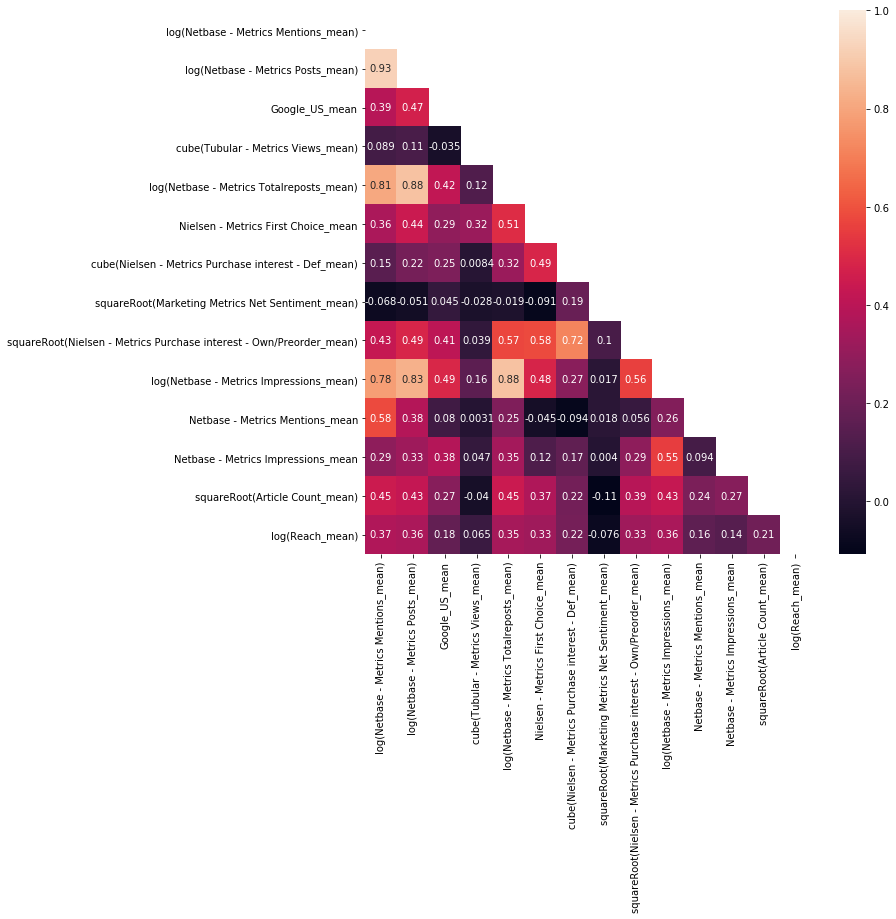

In [61]:
#Create a correlation plot based on need
#import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline
corr = df_rev_vif.corr()
corr.to_excel(path+"\\corr10features.xlsx")
fig, ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
sns_plot = sns.heatmap(corr,mask=mask,ax=ax,annot=True)
fig = sns_plot.get_figure()
fig.savefig(path+"\\corr_plot.png")
sns_plot
#corr.to_excel(path+"correlation_plot.xlsx")

In [118]:
#Checking the feature importances of the model
scores['estimator'][0].feature_importances_

array([0.03694627, 0.03891292, 0.1496335 , 0.06157803, 0.03860063,
       0.21525619, 0.11994338, 0.0261806 , 0.04384644, 0.03227007,
       0.07549348, 0.1613385 ])

In [119]:
#Printing model error metrics
print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

42.75963669343503
15.163461071125676
0.9390834323557413
0.9390834323557413


In [120]:
#Exporting the predictions & actual values 
#Exporting the feature importances of the variables in place

df_model_cv_prediction = df_transformed[['US_Revenue']]
feature_importances = pd.DataFrame()
feature_importances['Features'] = df_rev_vif.columns
count = 0
for model in scores['estimator']:
    pred = model.predict(df_rev_vif)
    feat_imp = model.feature_importances_
    df_model_cv_prediction['model_'+str(count)] = pred
    feature_importances['model_'+str(count)] = feat_imp
    count = count+1
df_model_cv_prediction['mean'] = df_model_cv_prediction.mean(axis=1)
df_model_cv_prediction.shape
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean',inplace=True,ascending=False)
feature_importances[['Features','mean']].to_excel(path+"//RF_feature_importances_new_US_Post_fin_0625_cis.xlsx")
df_model_cv_prediction[['US_Revenue','mean']].to_excel(path+"//New_check_US_Post_fin_0625_cis.xlsx")

c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [2]:
#Printing the top features from the model's output

#df_model_cv_prediction
feature_importances[['Features','mean']]

In [122]:
## Cross Validation for XGB
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import xgboost as xgb

mape_score = make_scorer(mean_absolute_percentage_error)
rsquare_score = make_scorer(Rsquare)
rank = np.linalg.matrix_rank(df_rev_vif)
print(df_rev_vif.shape)
print(rank)
adjRsquare_score = make_scorer(adjRsquare,rank = rank)
wmape_score = make_scorer(w_mape)
scoring = {'Rsquare':rsquare_score,'adjRsquare':adjRsquare_score,'mape':mape_score,'wmape':wmape_score}
gbm= xgb.XGBRegressor(n_estimators=1000,max_depth=6,max_features=int(df_rev_vif.shape[1]/3),random_state=7)
predictions = cross_val_predict(gbm, df_rev_vif,df_transformed['US_Revenue'], cv=8) 
scores = cross_validate(gbm,df_rev_vif,df_transformed['US_Revenue'],cv=8,scoring = scoring,return_train_score=True,return_estimator=True)

(67, 12)
1
[07:56:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\xabarbad\appdata\local\continuum\anaconda3\envs\virtual_kpi\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:56:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:02] WARNI

In [123]:
#Print the scores for the XG Boost model
scores

{'fit_time': array([0.26529956, 0.3560462 , 0.28423953, 0.30917215, 0.25033164,
        0.30618   , 0.32413173, 0.2722702 ]),
 'score_time': array([0.00996375, 0.0299201 , 0.00698209, 0.00698256, 0.01396275,
        0.01100826, 0.01097107, 0.01297212]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=6, max_features=4, min_child_weight=1, missing=None,
               n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
               random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
         

In [124]:
#Check the test, training error & the r-squared values

print(scores['test_wmape'].mean())
print(scores['train_wmape'].mean())
print(scores['train_Rsquare'].mean())
print(scores['train_adjRsquare'].mean())

38.58296821748873
3.364982474288848e-05
0.9999999999995463
0.9999999999995463
